<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Pyro - Bayesian regression

Here, we try to use a *deterministic* neural network, and a *stochastic* observation noise.

This causes nasty bugs in the SVI logic (double pass in backward pass)

Do NOT use this
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# NB Warning : setting the default_device to CUDA creates a device conflict
# when using a DataLoader, as it uses a CPU-generator for shuffling
torch.set_default_device(device)

print(f"Using {device}")
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

torch.set_default_dtype(torch.float32)

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
0 : Generate synthetic data
</div>

In [4]:
def target_function(X:torch.Tensor) -> torch.Tensor:
    y = X * torch.sin(6*torch.pi*X)
    return y

N_POINTS = 100

noise = torch.tensor([0.1])
X = torch.linspace(0.0, 1.0, steps=N_POINTS)
y = target_function(X) + torch.randn(N_POINTS)*noise

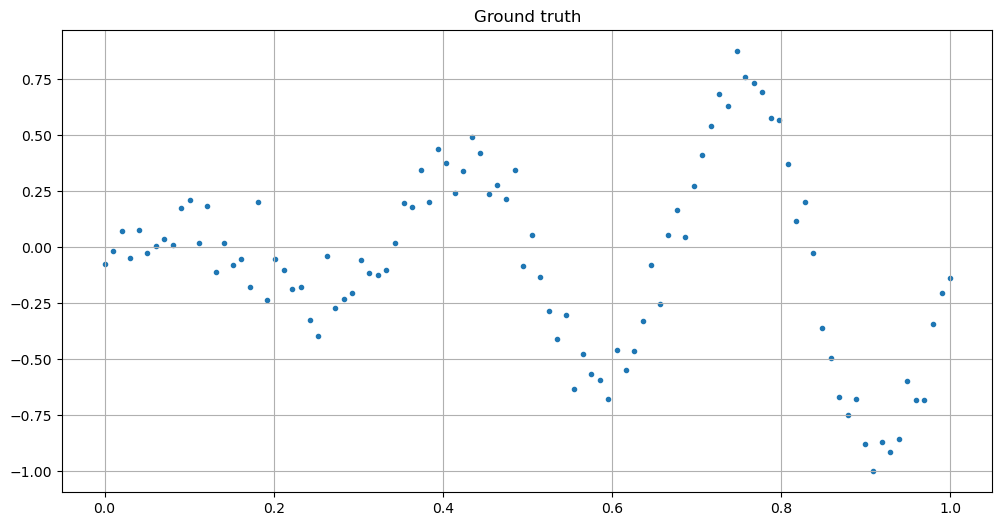

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(X.cpu(),y.cpu(),label='ground truth', marker='.')
ax.grid()
ax.set_title(f'Ground truth')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
1 : Pyro model with a deterministic neural network : CAREFUL
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
Final Rule for Hybrid SVI Models after a lengthy and painful debugging
</div>

The practical rule learned from this extensive debugging session is:

For deep, deterministic neural networks optimized via Pyro's SVI, avoid using the nn.Module.forward() method inside the model function. 

Instead, use the functional API (F.linear, F.relu, etc.) after manually retrieving the weights and biases from the parameter store using pyro.param().

This guarantees that the PyTorch autograd system receives the simplest, cleanest computational graph possible, resolving the persistent RuntimeError.

In [6]:
# deterministic part : neural network

class MLP(nn.Module):
    """
    The usual basic MLP class
    """
    def __init__(self, n_layers=2, n_hidden_units=32, activation=nn.Tanh(), input_dim=1, output_dim=1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.n_layers = n_layers
        self.n_hidden_units = n_hidden_units
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        
        self.fc1 = nn.Linear(input_dim, n_hidden_units)
        self.fc2 = nn.Linear(n_hidden_units, n_hidden_units)
        self.fc3 = nn.Linear(n_hidden_units, output_dim)
        
    def forward(self,x):
        # We don't use this, as this causes nasty conflicts with the SVI logic
        # but keep it for completeness
        x_ = x.unsqueeze(1) if x.dim() == 1 else x
        x_ = self.activation(self.fc1(x_))
        x_ = self.activation(self.fc2(x_))
        x_ = self.fc3(x_)
        
        return x_.squeeze()
    
    def __repr__(self):
        msg = f'object MLP - input dim = {self.input_dim}, output_dim = {self.output_dim}, num layers = {self.n_layers}, hidden units = {self.n_hidden_units}\n'
        msg += super().__repr__()
        return msg
    
mlp = MLP()

In [7]:
# Simple regression model
# the learned function is deterministic (this is the MLP)
# the observation noise is a random variable

# we need to register manually the weights of the MLP
# and run the forward pass manually...

def model(X, y=None):
    # # inputs: ----------------------
    # #   X : torch.tensor(N,1)
    # #   y : torch.tensor(N,1) if provided
      
    # priors ---------------------------------
    # the only prior, for now, is the log standard deviation of the gaussian observation noise
    log_noise_std = torch.exp(pyro.sample("log_noise_std", dist.Normal(0.0, 0.1)))
    
    # parameters : retrieve all deterministic MLP parameters manually
    params = {}
    for name, _ in mlp.named_parameters():
        params[name] = pyro.param(f"det_{name}")
        
    # 3. Manually run the forward pass
    activation = nn.Tanh()
    x_ = X.unsqueeze(1) if X.dim() == 1 else X
    x_ = activation(F.linear(x_, params['fc1.weight'], params['fc1.bias']))
    x_ = activation(F.linear(x_, params['fc2.weight'], params['fc2.bias']))
    x_ = F.linear(x_, params['fc3.weight'], params['fc3.bias'])
    means = x_.squeeze()
    
    # 4. Likelihood
    noise_std = torch.exp(log_noise_std)
    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(means, noise_std), obs=y)
    
    return means

In [8]:
# to learn the parameters, we implement a SVI without an approximate posterior
def q_phi(X,y=None):
    """
    the approximate posterior of the log noise standard deviation
    """
    # learnable parameters for the log of the standard deviation of the observation noise
    log_noise_std_loc = pyro.param("log_noise_std_loc", torch.tensor(-2.0))
    log_noise_std_std = pyro.param("log_noise_std_scale", torch.tensor((0.1)), constraint=constraints.positive)
    
    # actual posterior for the log_noise_std
    pyro.sample("log_noise_std", dist.Normal(log_noise_std_loc, log_noise_std_std))    
    
    # Manually register all MLP parameters
    for name, param in mlp.named_parameters():
        pyro.param(f"det_{name}", param.data)

In [9]:
# optimizer - using the Pyro wrapper for Adam
optimizer = Adam(
    {"lr": 1e-2}
)

# instantiate the SVI engine
svi = SVI(
    model=model,
    guide=q_phi,
    optim=optimizer,
    loss=Trace_ELBO(retain_graph=True)
)

In [10]:
# Clear old parameters
pyro.clear_param_store()
# debug
torch.autograd.set_detect_anomaly(True)

# training parameters
n_epochs = 2000
training_losses = []
validation_losses = []

for step in range(n_epochs):
    # perform the training : compute and backprop gradients
    loss = svi.step(X,y)
    # perform evaluation only
    with torch.no_grad():
        eval_loss = svi.evaluate_loss(X,y)
    # log the results
    training_losses.append(loss)
    validation_losses.append(eval_loss)
    # get the parameters
    est_log_noise_std_loc = pyro.param("log_noise_std_loc")
    est_log_noise_std_std = pyro.param("log_noise_std_scale")
    est_noise_std_loc = torch.exp(est_log_noise_std_loc)
    # report out
    print(f'Epoch {step+1:<6} / {n_epochs:<6} - loss = {loss:.3e} - val loss = {eval_loss:.3e} -- est. noise std mean : {est_noise_std_loc.item():.3f}')

Epoch 1      / 2000   - loss = 3.195e+02 - val loss = 3.356e+02 -- est. noise std mean : 0.137
Epoch 2      / 2000   - loss = 3.152e+02 - val loss = 3.268e+02 -- est. noise std mean : 0.138
Epoch 3      / 2000   - loss = 2.920e+02 - val loss = 2.804e+02 -- est. noise std mean : 0.139
Epoch 4      / 2000   - loss = 3.268e+02 - val loss = 3.005e+02 -- est. noise std mean : 0.141
Epoch 5      / 2000   - loss = 3.224e+02 - val loss = 2.967e+02 -- est. noise std mean : 0.142
Epoch 6      / 2000   - loss = 3.070e+02 - val loss = 3.201e+02 -- est. noise std mean : 0.144
Epoch 7      / 2000   - loss = 3.118e+02 - val loss = 3.011e+02 -- est. noise std mean : 0.145
Epoch 8      / 2000   - loss = 2.684e+02 - val loss = 2.926e+02 -- est. noise std mean : 0.147
Epoch 9      / 2000   - loss = 3.135e+02 - val loss = 2.946e+02 -- est. noise std mean : 0.148
Epoch 10     / 2000   - loss = 2.965e+02 - val loss = 3.000e+02 -- est. noise std mean : 0.150
Epoch 11     / 2000   - loss = 3.260e+02 - val los

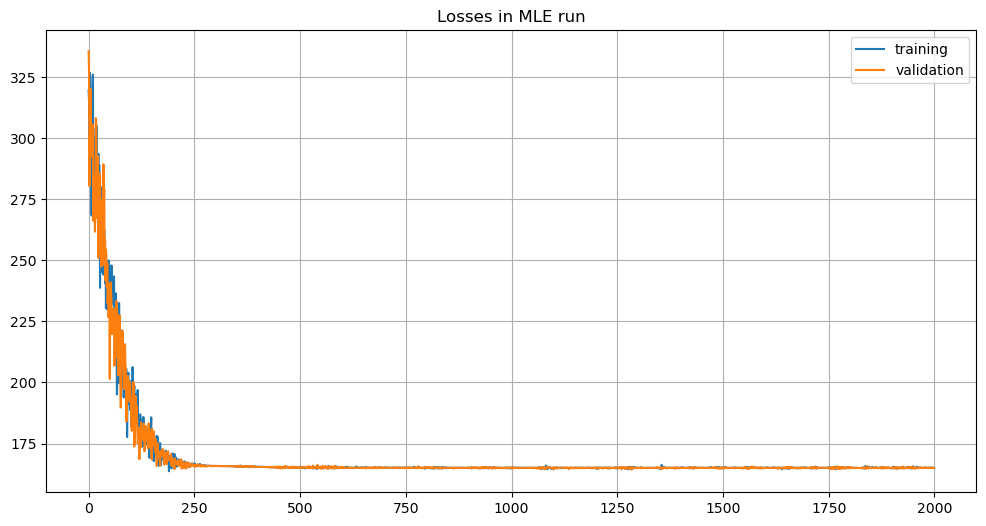

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(training_losses, label='training')
ax.plot(validation_losses, label='validation')
ax.set_title(f'Losses in MLE run')
ax.grid()
ax.legend()
plt.show()

In [12]:
print(f"Ground truth = {noise.item():.3f}, learned noise = {est_noise_std_loc.item():.3f}")

Ground truth = 0.100, learned noise = 0.573


In [ ]:
# here, we want to draw samples from the trained model on known X's
import pyro.poutine as poutine

N_SAMPLES = 1000
N_POINTS = X.shape[0]

# place holder for predictions.
# at each point, draw samples of the predicted value.
y_preds = torch.zeros((N_POINTS, N_SAMPLES)).to(device)

for s in range(N_SAMPLES):
    # STEP 1: Trace the execution of the prediction guide.
    # The trace records the *value* of the sampled parameters (a, b, log_noise_std).
    # posterior_trace = poutine.trace(posterior_sampler).get_trace(X)
    # NB : here we used the q_phi guide/approximate posterior, and 
    #       did not write a specific simpler posterior sampler
    posterior_trace = poutine.trace(q_phi).get_trace(X)
    
    # STEP 2: Use the Replay Poutine on the Model.
    # This forces the Model to use the parameter values recorded in guide_trace.
    with poutine.replay(trace=posterior_trace):
        # STEP 3: Execute the Model to draw a prediction.
        # Calling model(X) with y=None tells the 'obs' site to draw a sample 
        # (the predicted y) using the replayed (fixed) parameters.
        predicted_y_vector = model(X, y=None) 
    
    # STEP 4: Store the resulting vector of predictions for all N_POINTS
    y_preds[:, s] = predicted_y_vector.squeeze()

print(f"Finished sampling {N_SAMPLES} predictive vectors.")

Finished sampling 1000 predictive vectors.


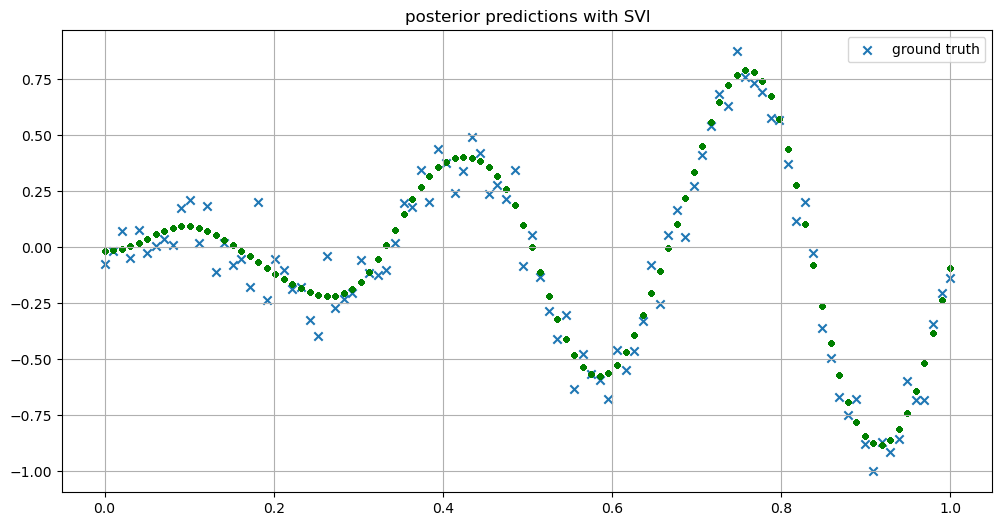

In [14]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(X.detach().cpu(),y.detach().cpu(), marker='x', label='ground truth')
ax.grid()
ax.legend()
ax.set_title(f'posterior predictions with SVI')
for s in range(N_SAMPLES):
    ax.scatter(X.cpu(), y_preds[:,s].detach().cpu(), alpha=0.05, color='green', marker='.')
plt.show()